
# **Hyperparameter Setting**


*   Learning_Rate : 0.001
*   Normoralization : x - 전체 데이터의 mean값 / 전체 데이터의 std값
*   Dataset_Structure : train_dataset(64%)|vaildation_dataset(16%)|test_dataset(20%)
*   Train_Batch_Size : 128
*   Test_Batch_Size : NULL(없음)
*   Random_State : 24
*   Epoch : 1000
*   DNN Activation_Function : relu
*   Metrics : mse, mae
*   Loss_Function : mse
*   Optimizer : RMSDprop
*   Dataset_Filename : Filtered_Dataset.npz
*   Label_Filename : Ground Truth.csv
*   Input_Size : 301
*   Hidden_Size : [100, 100, 50]









# 1. Data loading & Dataset setting



  1-1. Load dataset

In [ ]:
import numpy as np
import pathlib
import pandas as pd
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from keras import layers
print(tf.__version__)

from keras.models import Sequential
from keras.layers import Dense, Activation
from keras.metrics import Accuracy
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

# Load dataset
# Convert array type : Numpy -> Pandas(DataFrame)
# Delete unused columns from array
dataset_column_names = [str(i) for i in range(301)]
label_column_names = ['index', 'Data_Num', 'Vth', 'Mobility', 'S-Slope', 'On/Off']
uploaded_dataset_label_path = 'Ground Truth.csv'
dataset = np.load('Filtered_Dataset.npz')['dataset']
dataset = pd.DataFrame(dataset)
label_dataset = pd.read_csv(uploaded_dataset_label_path, names = label_column_names,
                          na_values="?", comment='\t', skipinitialspace=True)
label_dataset.drop('Data_Num', axis=1, inplace=True)
label_dataset.drop('index', axis=1, inplace=True)


2.15.0


1-2. Setting input data

In [ ]:

# Make One-hot Vector label data
# Split 'Mobility' column from label_dataset(Vth, Mobility, SS, On/Off)
label_mobility = label_dataset['On/Off'].copy()
label_mobility = label_mobility.drop(0)
label_mobility = label_mobility.reset_index(drop=True)
label_mobility = label_mobility.astype(float)



# Make dataset used for model [ measured feature (idx:0~300) | mobility (idx:301)]
dataset = pd.concat([dataset, label_mobility], axis=1)
train_dataset = dataset.sample(frac=0.8,random_state=24)
test_dataset = dataset.drop(train_dataset.index)


1-3. Visualize input data

,count,mean,std,min,25%,50%,75%,max
0,319.0,6.830831e-10,1.194990e-08,8.000000e-12,1.200000e-11,1.330000e-11,1.500000e-11,2.134460e-07
1,319.0,5.117618e-11,6.982215e-10,6.400000e-12,1.020000e-11,1.180000e-11,1.325000e-11,1.248260e-08
2,319.0,1.351411e-11,4.408241e-11,5.400000e-12,9.200000e-12,1.070000e-11,1.230000e-11,7.967000e-10
3,319.0,1.038056e-11,3.316549e-12,4.100000e-12,8.500000e-12,9.900000e-12,1.140000e-11,3.140000e-11
4,319.0,9.866771e-12,2.963408e-12,4.400000e-12,8.000000e-12,9.500000e-12,1.110000e-11,2.590000e-11
...,...,...,...,...,...,...,...,...
296,319.0,3.536472e-03,3.862668e-04,2.371390e-03,3.223610e-03,3.548210e-03,3.843910e-03,4.640530e-03
297,319.0,3.572408e-03,3.897917e-04,2.396420e-03,3.256420e-03,3.585260e-03,3.883210e-03,4.685200e-03
298,319.0,3.608347e-03,3.934946e-04,2.417710e-03,3.289355e-03,3.622060e-03,3.922505e-03,4.729130e-03
299,319.0,3.644465e-03,3.970520e-04,2.443580e-03,3.322395e-03,3.658880e-03,3.962140e-03,4.773160e-03


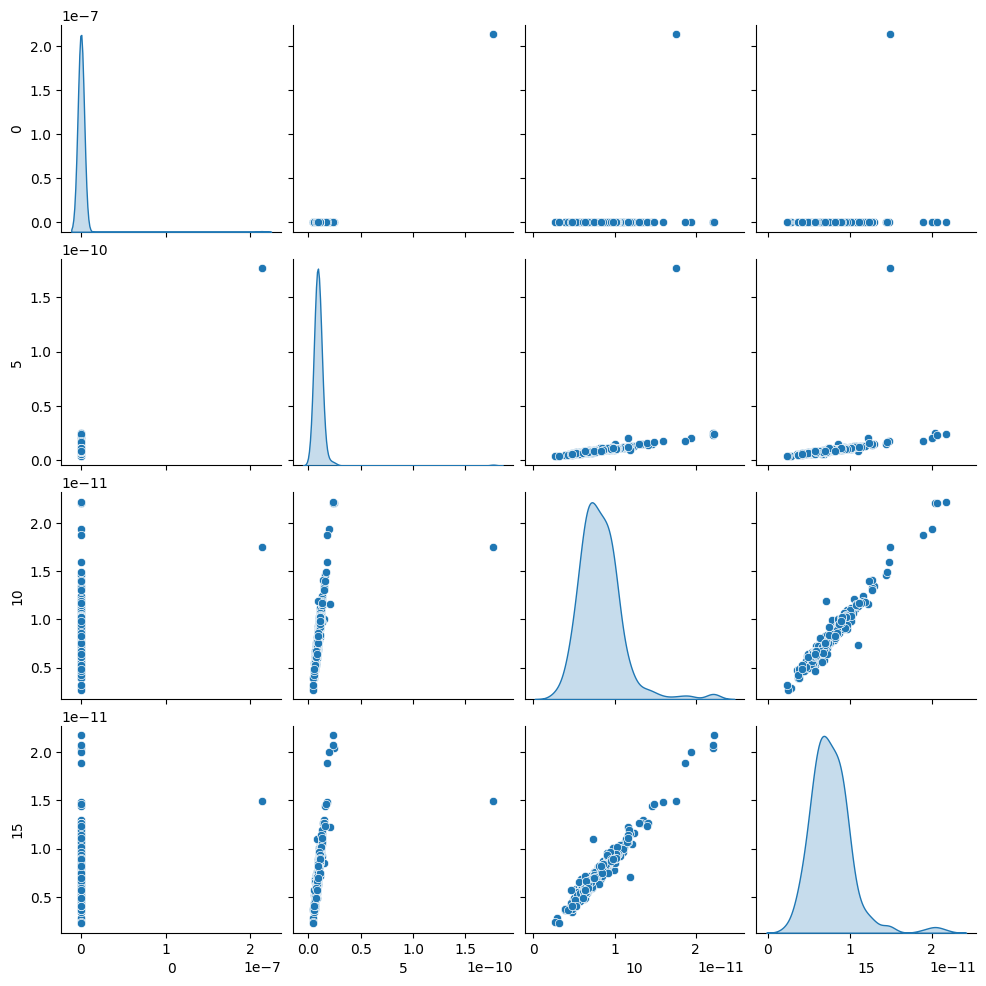

In [ ]:

# VIsualize train_dataset
sns.pairplot(train_dataset[[0, 5, 10, 15]], diag_kind="kde")

# Statistic feature of train_dataset
train_stats = train_dataset.describe()
train_stats.pop('On/Off')
train_stats = train_stats.transpose()
train_stats


1-4. Split train data, train data's label, test data, test data's label

In [ ]:

# Detach 'Mobility' column from train_dataset & test_dataset
train_labels = train_dataset.pop('On/Off')
test_labels = test_dataset.pop('On/Off')

# Data Normalization - standardization
def norm(x):
  return (x - train_stats['mean']) / train_stats['std']
#normed_train_data = norm(train_dataset)
#normed_test_data = norm(test_dataset)

def norm_log10(x):
  return (np.log10(x))

train_labels = norm_log10(train_labels)
test_labels = norm_log10(test_labels)

normed_train_data = norm_log10(train_dataset)
normed_test_data = norm_log10(test_dataset)

# Data Normalization - log10 transform
#--------------------------------------
#train_input = np.log10(train_input)
#test_input = np.log10(test_input)

# OnOff Ratio ground truth Normalization
# train_target = np.log10(train_labels)
# test_target = np.log10(test_labels)




---



# 2. Construct DNN structure

In [ ]:

def build_model():
  model = keras.Sequential([
    layers.Dense(100, activation='relu', input_shape=[len(train_dataset.keys())]),
    layers.Dense(100, activation='relu'),
    layers.Dense(50, activation='relu'),
    layers.Dense(1)
  ])

  optimizer = tf.keras.optimizers.RMSprop(0.001)

  model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae', 'mse'])
  return model

model = build_model()
model.summary()


Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_40 (Dense)            (None, 100)               30200     
                                                                 
 dense_41 (Dense)            (None, 100)               10100     
                                                                 
 dense_42 (Dense)            (None, 50)                5050      
                                                                 
 dense_43 (Dense)            (None, 1)                 51        
                                                                 
Total params: 45401 (177.35 KB)
Trainable params: 45401 (177.35 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________




---



# 3. train

In [ ]:

# 10 Batch size for normed_train_data
example_batch = normed_train_data[:10]
example_result = model.predict(example_batch)
example_result

# While each epoch ended, print dot(.) to visualize train process
class PrintDot(keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs):
    if epoch % 100 == 0: print('')
    print('.', end='')

# 1000 Epochs
EPOCHS = 1000

# Training
history = model.fit(
  normed_train_data, train_labels,
  epochs=EPOCHS, validation_split = 0.2, verbose=0, batch_size = 128,
  callbacks=[PrintDot()])


1/1 [==============================] - 0s 70ms/step

....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
......................................

 3-1. Visualize model training process

In [ ]:

hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()


,loss,mae,mse,val_loss,val_mae,val_mse,epoch
995,0.098915,0.276660,0.098915,0.138798,0.348494,0.138798,995
996,0.130003,0.327578,0.130003,0.162137,0.379592,0.162137,996
997,0.147800,0.361512,0.147800,0.178103,0.401534,0.178103,997
998,0.161263,0.373313,0.161263,0.187574,0.413148,0.187574,998
999,0.164681,0.385243,0.164681,0.171155,0.392755,0.171155,999


3-2. Training without EarlyStopping callback

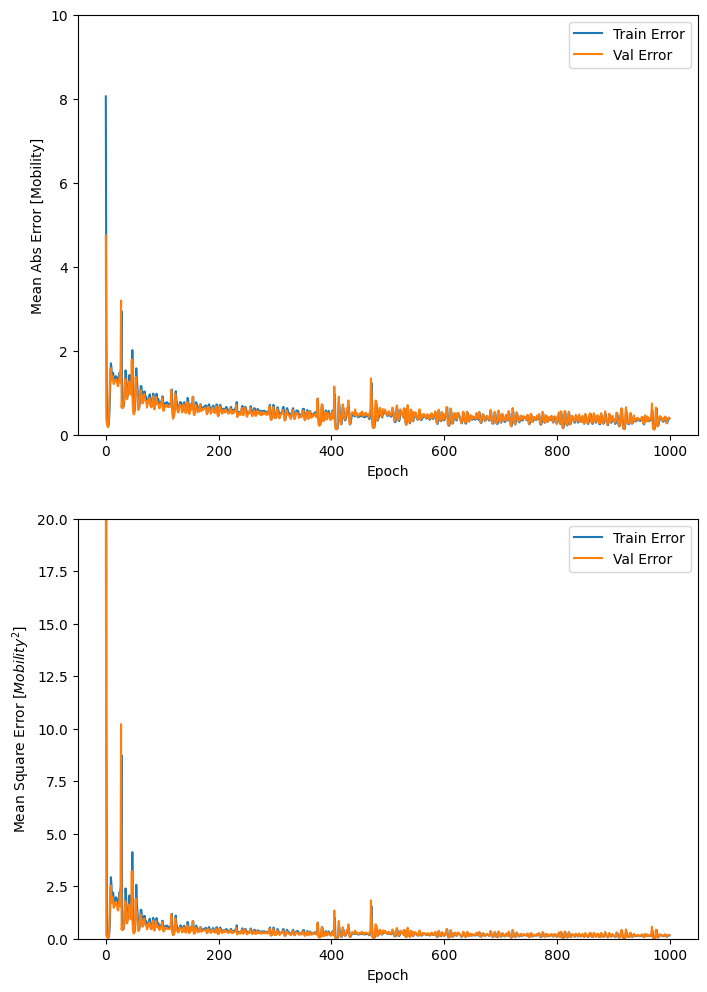

In [ ]:
import matplotlib.pyplot as plt

def plot_history(history):
  hist = pd.DataFrame(history.history)
  hist['epoch'] = history.epoch

  plt.figure(figsize=(8,12))

  plt.subplot(2,1,1)
  plt.xlabel('Epoch')
  plt.ylabel('Mean Abs Error [Mobility]')
  plt.plot(hist['epoch'], hist['mae'],
           label='Train Error')
  plt.plot(hist['epoch'], hist['val_mae'],
           label = 'Val Error')
  plt.ylim([0,10])
  plt.legend()

  plt.subplot(2,1,2)
  plt.xlabel('Epoch')
  plt.ylabel('Mean Square Error [$Mobility^2$]')
  plt.plot(hist['epoch'], hist['mse'],
           label='Train Error')
  plt.plot(hist['epoch'], hist['val_mse'],
           label = 'Val Error')
  plt.ylim([0,20])
  plt.legend()
  plt.show()

plot_history(history)

3-3. Train with EarlyStopping callback


....................................................................................................
....

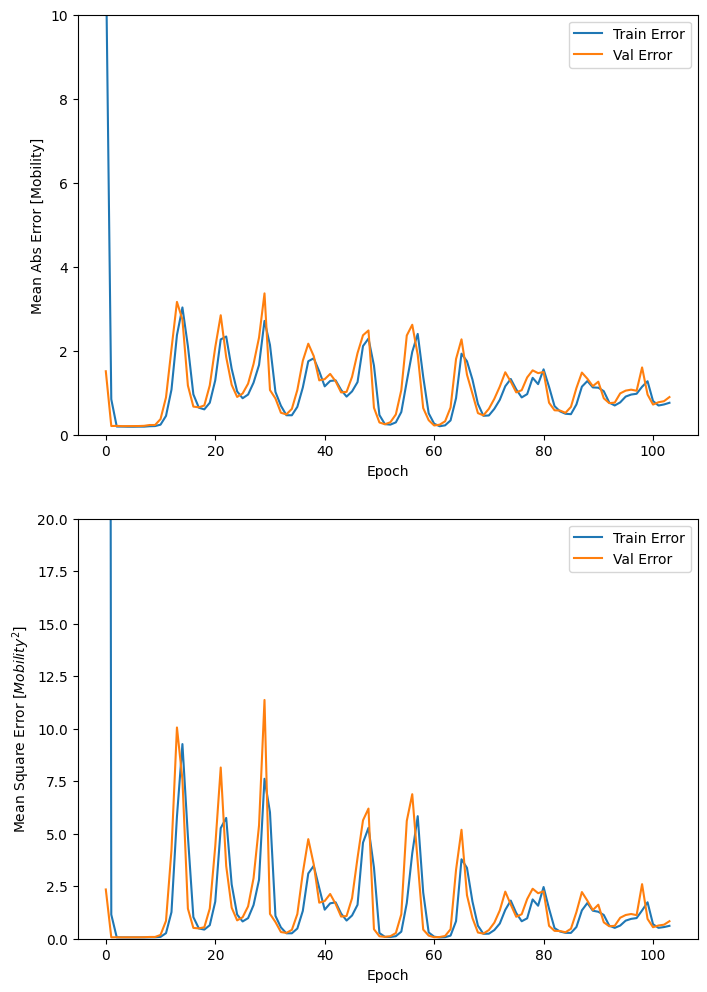

In [ ]:
model = build_model()

# patience parameter is a epoch size for checking performance improvement
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=100)

# train
history = model.fit(normed_train_data, train_labels, epochs=EPOCHS, batch_size = 128,
                    validation_split = 0.2, verbose=0, callbacks=[early_stop, PrintDot()])

plot_history(history)



---



# 5. Test

In [ ]:

# For model evaluation, change Pandas(DataFrame) to Numpy with float type
normed_test_data_array = normed_test_data.to_numpy().astype(float)

# Test
loss, mae, mse = model.evaluate(normed_test_data_array, test_labels, verbose=2)

print("테스트 세트의 평균 절대 오차: {:5.2f} MPG".format(mae))


3/3 - 0s - loss: 0.7088 - mae: 0.8282 - mse: 0.7088 - 139ms/epoch - 46ms/step
테스트 세트의 평균 절대 오차:  0.83 MPG


5-1. Visualize Prediction (with test data)

In [1]:

test_predictions = model.predict(normed_test_data).flatten()

# 로그를 다시 원래 값으로 되돌리기
# test_labels = np.power(10, test_labels)
# test_predictions = np.power(10, test_predictions)

print(test_predictions[0:5])

# 산포도 그리기
plt.scatter(test_labels, test_predictions)
plt.xlabel('True Values [Mobility]')
plt.ylabel('Predictions [Mobility]')
plt.axis('equal')
plt.axis('square')

# xlim과 ylim 설정
max_value = max(np.max(test_labels), np.max(test_predictions))
plt.xlim([0, max_value])
plt.ylim([0, max_value])

# 대각선 1:1 라인 그리기
_ = plt.plot([0, max_value], [0, max_value], color='red')

# 그래프 보여주기
plt.show()


NameError: name 'model' is not defined

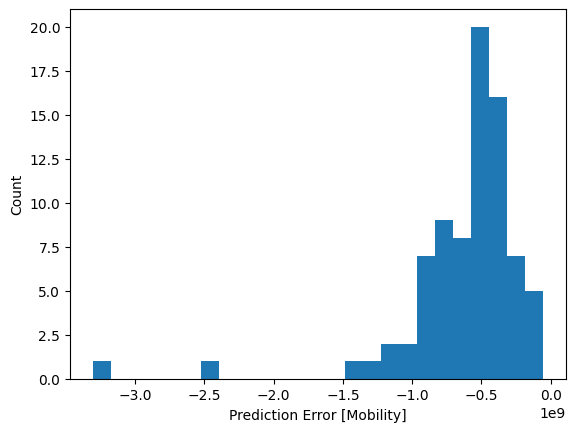

In [ ]:
error = test_predictions - test_labels
plt.hist(error, bins = 25)
plt.xlabel("Prediction Error [Mobility]")
_ = plt.ylabel("Count")